## Team Members

Shivam Thakker

Karthik Varunn

Abdelrahman Zeidan

Rashaad Mirza

## Importing necessary libraries

In [18]:
import csv
import pandas as pd
import contractions
from sklearn.preprocessing import StandardScaler
import regex as re
import swifter
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from autocorrect import Speller
from datetime import datetime


nltk.download('stopwords')


df = pd.read_csv("C:/Users/thakk/Academics/Courses/NLP/Assignment A1/patient_notes.csv")


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\thakk\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Part 1: Data Preprocessing

In [19]:
#Replaces punctuation with spaces
def replace_punctuation_with_spaces(text):
    return re.sub(r'[^a-zA-Z0-9\s]+', ' ', text)



#Perform Contractions
def perform_contractions(text):
    text_1 = contractions.fix(text)
    return text_1



#Standardize Formats
def standardize_formats(text):
    # Standardize Dates 
    date_formats = [
        r'\b(\d{1,2})[-/](\d{1,2})[-/](\d{2,4})\b',  
        r'\b(\d{2,4})[-/](\d{1,2})[-/](\d{1,2})\b', 
    ]
    for date_format in date_formats:
        text = re.sub(date_format, lambda x: datetime(*map(int, x.groups())).strftime('%Y-%m-%d'), text)

    # Standardize Currencies (e.g., $1,000,000 to $1000000)
    text = re.sub(r'\$\s?(\d+(?:,\d{3})*(?:\.\d{1,2})?)', lambda x: '${:,.2f}'.format(float(x.group(1).replace(',', ''))), text)

    # Standardize large numbers (e.g., 1,000,000 to 1000000)
    text = re.sub(r'(\d{1,3})(?=(\d{3})+(?!\d))', r'\1,', text)

    # Standardize decimal points (e.g., 1,000.00 to 1000.00)
    text = re.sub(r'(\d+),(\d+)', r'\1.\2', text)

    return text



#Remove Stopwords and add custom stopwords
def remove_stopwords():
    
    stopword_to_remove = ["he", "him", "his", "himself", "she", "she's", "her", "hers", "herself"] 
    stopword_list = stopwords.words('english')
    stopwords_to_add = ["patient", "health", "doctor", "nurse", "hospital", "clinic", "medical", "medicine", "medication", "medications", "medicines"]

    for i in stopword_to_remove:
        try:
            stopword_list.remove(i)
        except:
            pass
    
    for i in stopwords_to_add:
        try:
            stopword_list.append(i)
        except:
            pass

    return stopword_list



#Correct typos and spelling errors using autocorrect
def typo_spell(note):
    spell = Speller(fast=True)
    note = ' '.join(spell(word) for word in note.split())
    return note



#Apply all the functions
df['pn_history'] = df['pn_history'].str.lower()

df['pn_history'] = df['pn_history'].swifter.apply(perform_contractions)

df['pn_history'] = df['pn_history'].swifter.apply(replace_punctuation_with_spaces)

df['pn_history'] = df['pn_history'].swifter.apply(standardize_formats)

stopword_list = remove_stopwords()
df['pn_history'] = df['pn_history'].swifter.apply(lambda x: ' '.join([word for word in x.split() if word not in (stopword_list)]))

df['pn_history'] = df['pn_history'].swifter.apply(typo_spell)

df.to_csv("./output.csv", index=False)

print(df.head())

Pandas Apply:   0%|          | 0/42146 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/42146 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/42146 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/42146 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/42146 [00:00<?, ?it/s]

   pn_num  case_num                                         pn_history
0       0         0  17 year old male come student complaining hear...
1       1         0  17 yo male recurrent palpitations past 3 mo la...
2       2         0  dillon cleveland 17 male significant pm presen...
3       3         0  17 yo c palpitation started 3 mos ago nothing ...
4       4         0  17yo male pm evaluation palpitations states la...


## Part 2: Document Term Matrix

In [50]:
#Tf-idf vectorization

vectorizer = TfidfVectorizer(
    stop_words="english",  # Remove common English stop words
    ngram_range=(1,1),  # Consider unigrams
    min_df=200,  # Ignore terms that appear in less than 200 documents
    max_df=0.8  # Ignore terms that appear in more than 80% of documents
)

X = vectorizer.fit_transform(df['pn_history'])
features = vectorizer.get_feature_names_out()

DTM = pd.DataFrame(X.toarray(), columns=features)
DTM.shape

(42146, 1310)

## Memory and Size of DTM

In [51]:
DTM.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42146 entries, 0 to 42145
Columns: 1310 entries, 10 to yrs
dtypes: float64(1310)
memory usage: 421.2 MB


## Part 3: Applying Unsupervised Machine Learning Algorithms

In [63]:
from sklearn.ensemble import IsolationForest
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score, silhouette_samples

## Outlier Analysis

In [22]:
# Outlier detection using Isolation Forest
model = IsolationForest(contamination=0.01)
df =  DTM

# Fit the model on the data
model.fit(df)
 
# Predict outliers/anomalies (1 for normal, -1 for anomaly)
predictions = model.predict(df)
 
# Add the predictions to the DataFrame
df['anomaly'] = predictions

In [23]:
df['anomaly'].value_counts()

anomaly
 1    41724
-1      422
Name: count, dtype: int64

In [24]:
# Remove the extra column anomaly that was added
df2 = df.drop(columns=['anomaly'])

## Standardization using StandardScaler

In [25]:
#Step 1: Standardization
scaler = StandardScaler()
DTM = scaler.fit_transform(DTM)

## Implementing UMAP for dimensionality reduction

In [53]:
import umap
from matplotlib import pyplot as plt
umap_model = umap.UMAP(n_neighbors=40, min_dist=0.5, n_components=2, metric='cosine', random_state=42)

# Fit and transform the data
X_umap = umap_model.fit_transform(DTM)
X_umap.shape

c:\Users\thakk\miniconda3\envs\temp\lib\site-packages\umap\umap_.py:1943: UserWarning:

n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.



(42146, 2)

In [54]:
kmeans_umap = KMeans(n_clusters=10, random_state=42)
umap_clusters = kmeans_umap.fit_predict(X_umap)

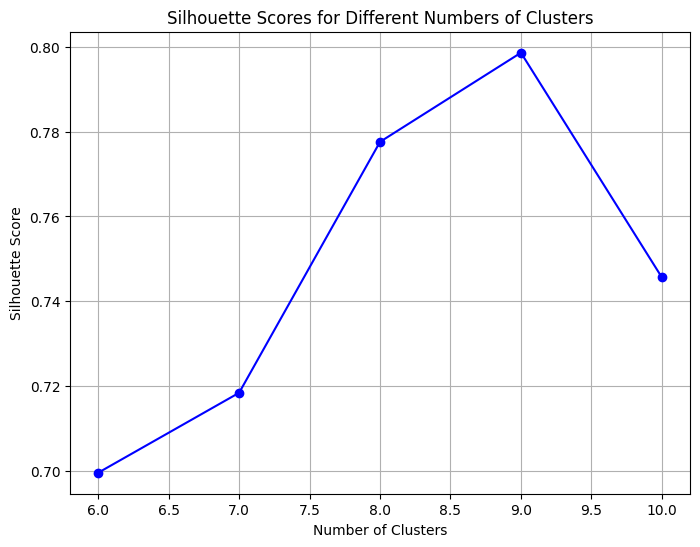

In [66]:
range_n_clusters = list(range(6, 11))

# Silhouette scores
silhouette_scores = []

for n_clusters in range_n_clusters:
    # KMeans clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(X_umap)

    # Silhouette score for each sample
    silhouette_avg = silhouette_score(X_umap, cluster_labels)
    silhouette_scores.append(silhouette_avg)

# Plot the line graph
plt.figure(figsize=(8, 6))
plt.plot(range_n_clusters, silhouette_scores, marker='o', linestyle='-', color='b')
plt.title('Silhouette Scores for Different Numbers of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.show()

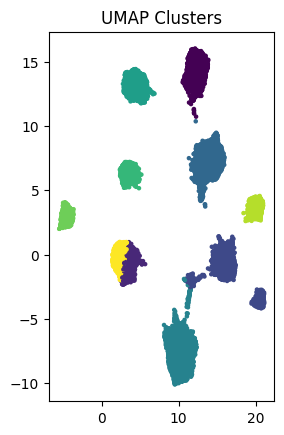

In [69]:
plt.subplot(1, 2, 2)
plt.scatter(X_umap[:, 0], X_umap[:, 1], c=umap_clusters, cmap='viridis', s=5)
plt.title('UMAP Clusters')
plt.show()

## PCA - finding the best n_components using the explained variance score

In [ ]:
# Initialize PCA model
pca = PCA(n_components=0.80, random_state=42)
dtm_reduced2 = pca.fit_transform(DTM)

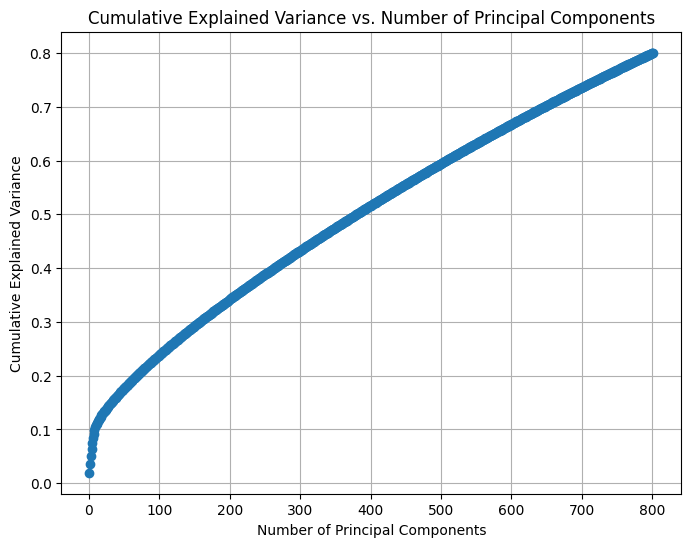

80 components can give an explainced score variance of 0.2 and this value will be used for the steps below


In [27]:
# Step 2: To find best n_components for pca

# Calculate the cumulative explained variance
cumulative_variance = pca.explained_variance_ratio_.cumsum()

# Plot the cumulative explained variance
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='-')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance vs. Number of Principal Components')
plt.grid()
plt.show()
print("80 components can give an explainced score variance of 0.2 and this value will be used for the steps below")

## KMeans - finding the best n_cluster value using silhouette scores

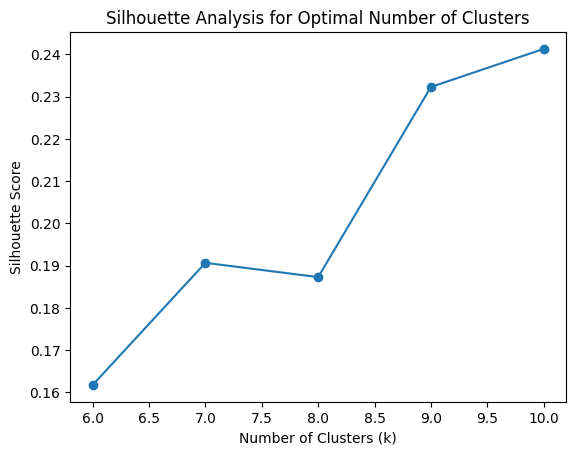

Optimak k value =  10


In [28]:
pca = PCA(n_components=80, random_state=42)
dtm_reduced2 = pca.fit_transform(DTM)

# Step 3: KMeans clustering with silhouette analysis
silhouette_scores = []
possible_k_values = range(6, 11)

for k in possible_k_values:
    kmeans = KMeans(n_clusters=k)
    cluster_labels = kmeans.fit_predict(dtm_reduced2)
    silhouette_avg = silhouette_score(dtm_reduced2, cluster_labels)
    silhouette_scores.append(silhouette_avg)
 
# Plot silhouette scores for each k
plt.plot(possible_k_values, silhouette_scores, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis for Optimal Number of Clusters')
plt.show()
 
# Choose the optimal number of clusters based on the silhouette analysis
optimal_k = possible_k_values[np.argmax(silhouette_scores)]
print("Optimak k value = ", optimal_k)

## Visualizing the final clustering using the previous results.

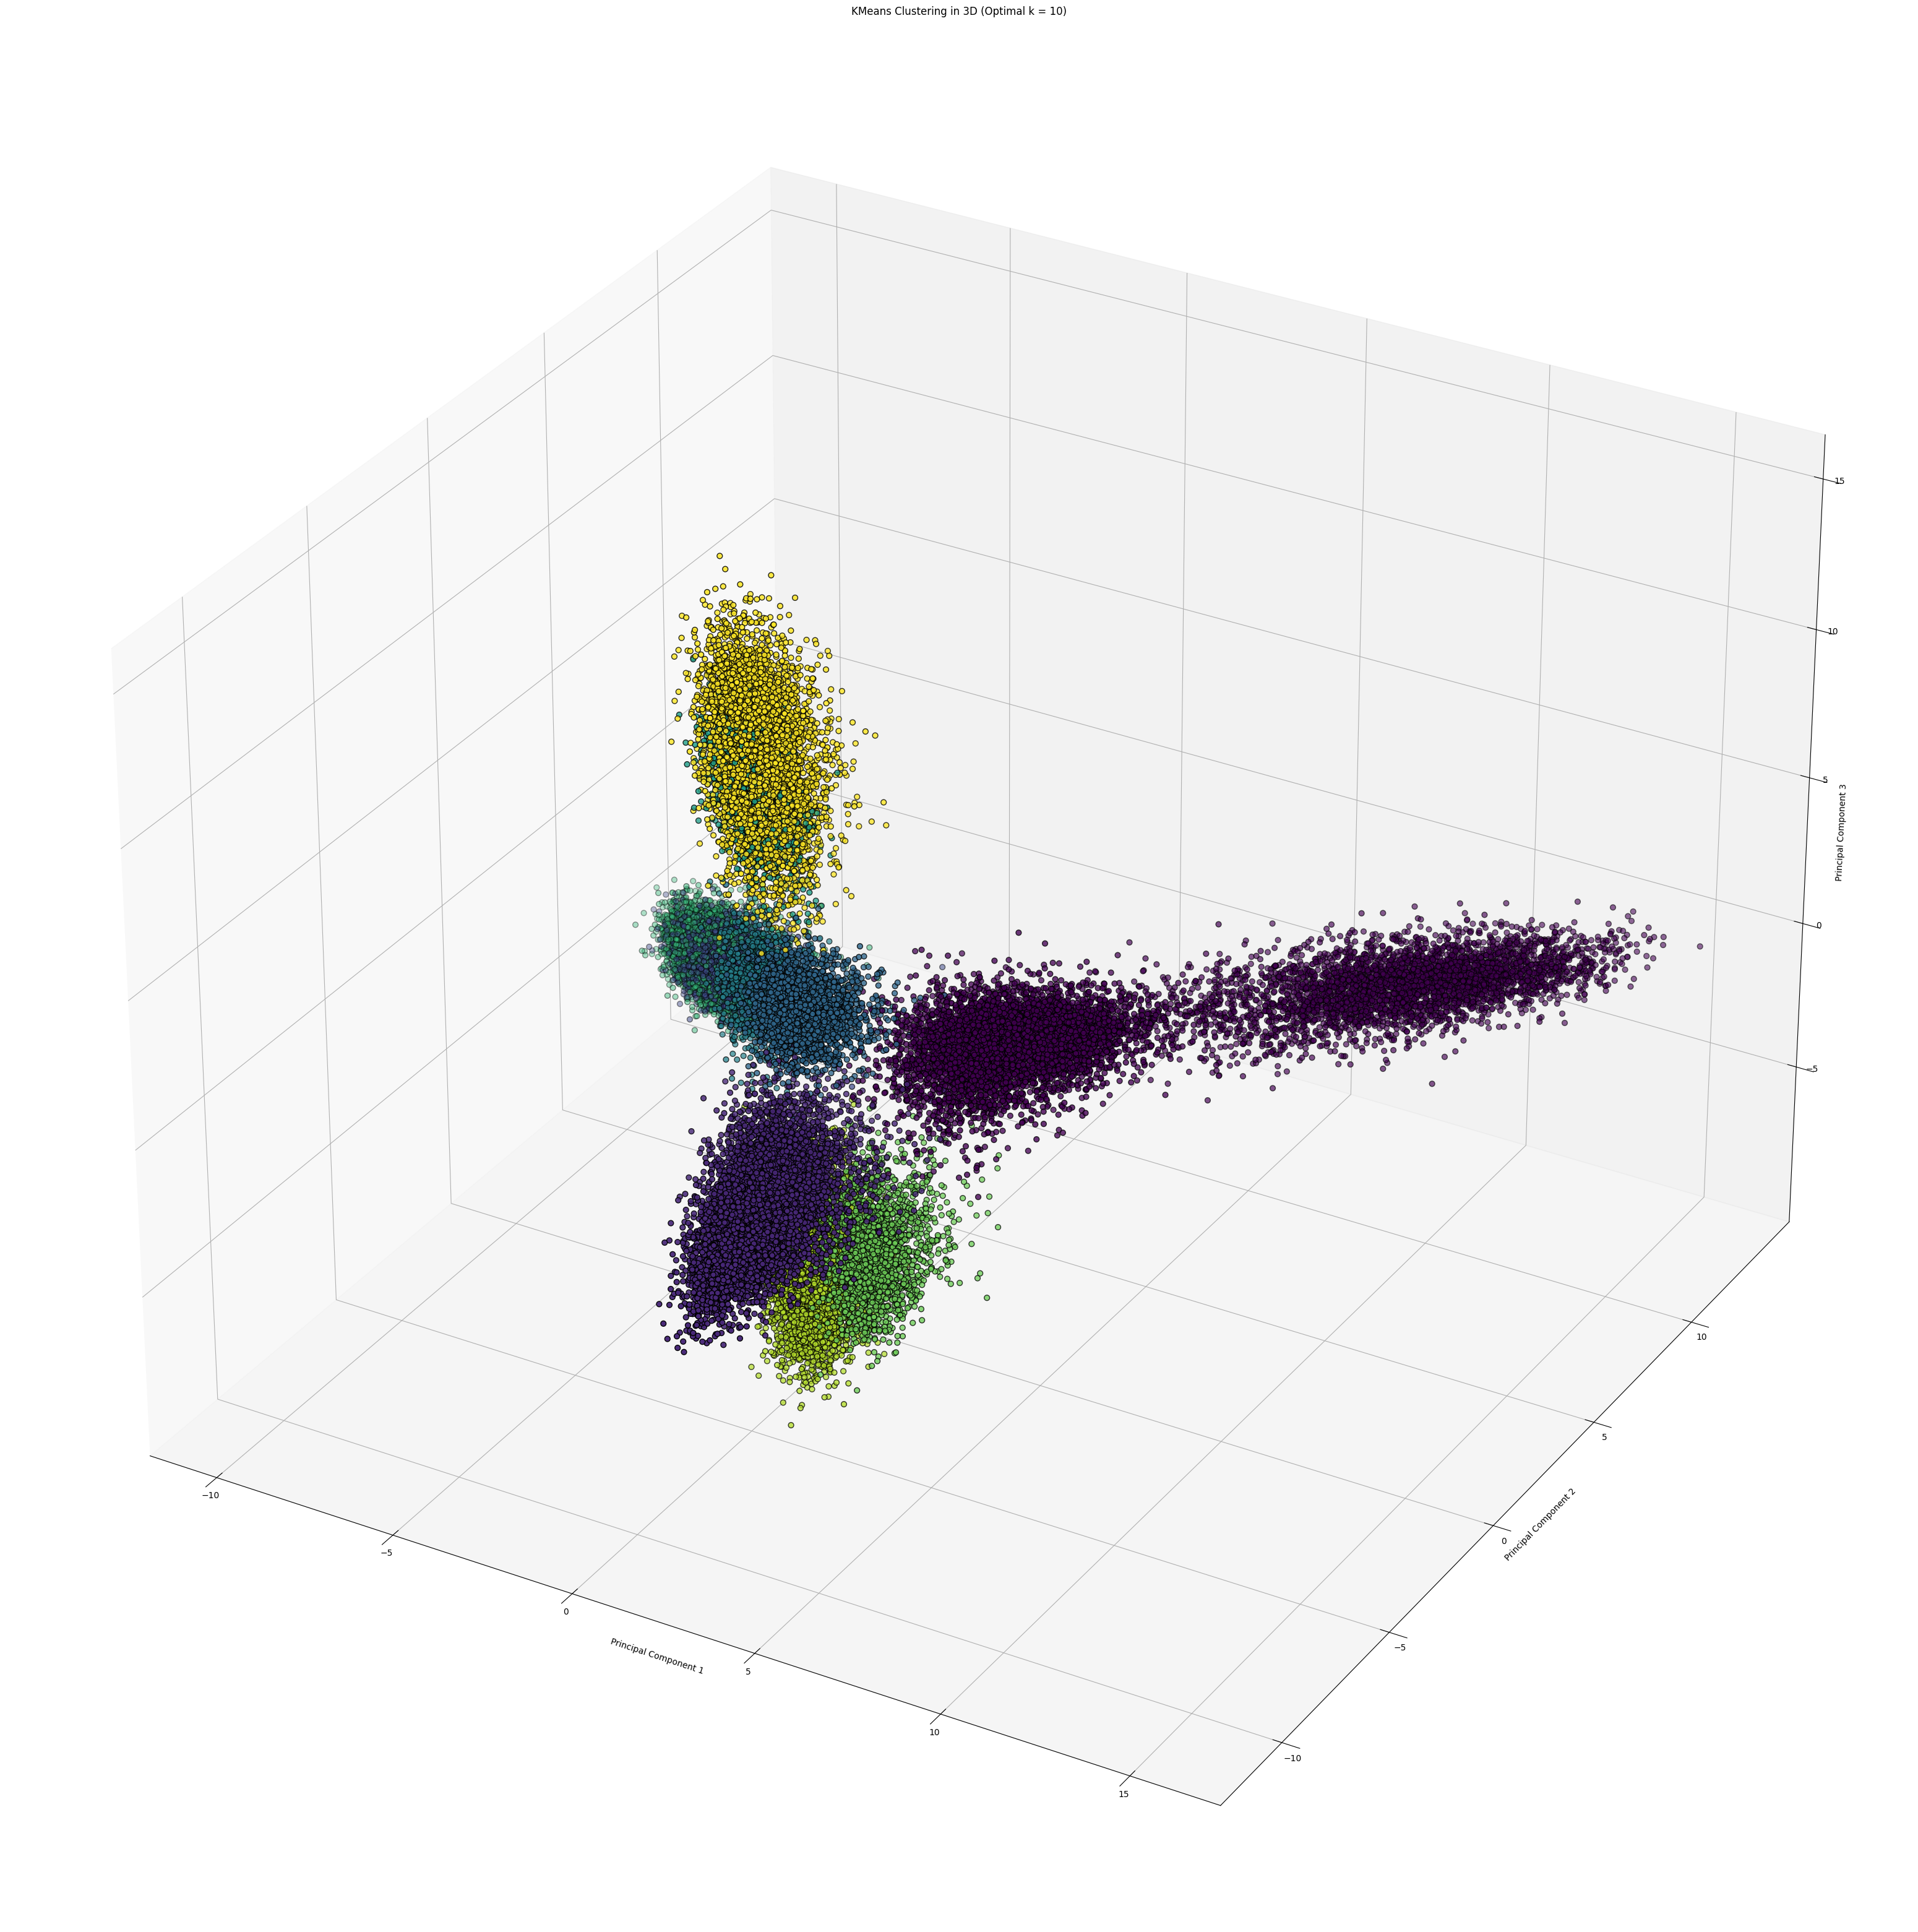

In [29]:
X_final_pca = dtm_reduced2

# Fit KMeans with the optimal number of clusters
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
cluster_labels = kmeans.fit_predict(X_final_pca)
 
# Create a 3D scatter plot of the first three principal components colored by cluster
fig = plt.figure(figsize=(50, 40))
ax = fig.add_subplot(111, projection='3d')
 
ax.scatter(X_final_pca[:, 0], X_final_pca[:, 1], X_final_pca[:, 2], c=cluster_labels, cmap='viridis', edgecolor='k', s=40)
ax.set_title('KMeans Clustering in 3D (Optimal k = {})'.format(optimal_k))
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
 
plt.show()

In [30]:
import plotly.express as px
 
# Create a DataFrame with the cluster labels
cluster_df = pd.DataFrame({'PC1': dtm_reduced2[:, 0], 'PC2': dtm_reduced2[:, 1], 'PC3': dtm_reduced2[:, 2], 'Cluster': cluster_labels})
 
# Create the interactive 3D scatter plot
fig = px.scatter_3d(cluster_df, x='PC1', y='PC2', z='PC3', color='Cluster', labels={'Cluster': 'Cluster'}, title='K-Means Clustering for 10 Clusters')
fig.update_traces(marker=dict(size=6))
fig.show()